In [1]:
pwd

'/mmfs1/data/aglinska/BC-ABCD-ADHD'

In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import ants

/data/aglinska/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
subs_td = pd.read_csv('./Derivatives/ABCD_NON_ADHD_subjectIDs_N_4021.csv')
subs_adhd = pd.read_csv('./Derivatives/ABCD_ADHD_subjectIDs_N_1017.csv')
subs=pd.concat([subs_td,subs_adhd])

subs = subs['subjectkey'].values
subs_orig = subs.copy()

subs = [f'sub-{val}'.replace('_','') for val in subs]
subs = np.array(subs)
print(len(subs))
print(subs[0:3])

5038
['sub-NDARINV5MJHVEB8' 'sub-NDARINV36E4JVZ2' 'sub-NDARINVKDZKAC4L']


In [4]:
# # _brain_arr_orig.npz
# #_brain_arr_aligned.npz
#arr_fn = './Data/ABCD-brains-T0/{sub}_brain_arr_aligned.npz'
arr_fn = './Data/ABCD-brains-T0/{sub}_brain_tiny_aligned.nii.gz'
#arr_fn = './Data/ABCD-brains-T0/{sub}_brain_tiny_orig.nii.gz'

In [5]:
check_exists = np.array([os.path.exists(arr_fn.format(sub=sub)) for sub in subs])

In [6]:
len(subs[~check_exists])

205

In [7]:
subs_use = subs[check_exists]
len(subs_use)

4833

In [8]:
# arr = np.array([np.load(arr_fn.format(sub=sub))['arr'] for sub in tqdm(subs_use)])
# print(arr.shape)

In [9]:
n = len(subs_use)

In [10]:
arr = np.zeros((n,64,64,64))
arr.shape

(4833, 64, 64, 64)

In [11]:
bad_subs = []
good_subs = []
for i in tqdm(range(n)):
    sub = subs_use[i]
    try:
        #subarr = np.load(arr_fn.format(sub=sub))['arr']
        subarr = ants.image_read(arr_fn.format(sub=sub)).numpy()
        good_subs.append(sub)
    except:
        bad_subs.append(sub)
        subarr = np.zeros((64,64,64))*np.nan
    arr[i,:,:,:] = subarr

100%|███████████████████████████████████████████████████████████████████████████████| 4833/4833 [00:54<00:00, 88.47it/s]


In [12]:
assert np.isnan(arr).sum()==0
assert arr.max()<=1.0

In [13]:
im = ants.image_read(arr_fn.format(sub=subs_use[0]))

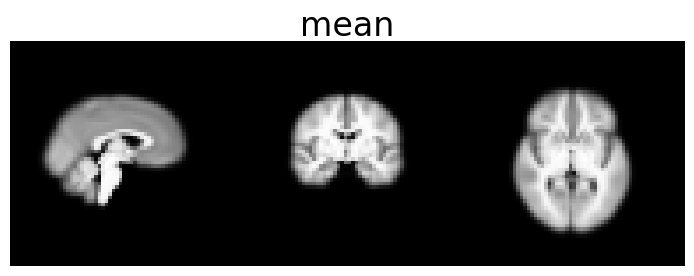

In [14]:
marr = arr.mean(axis=0)
im.new_image_like(marr).plot_ortho(flat=True,xyz_lines=False,orient_labels=False,title='mean')

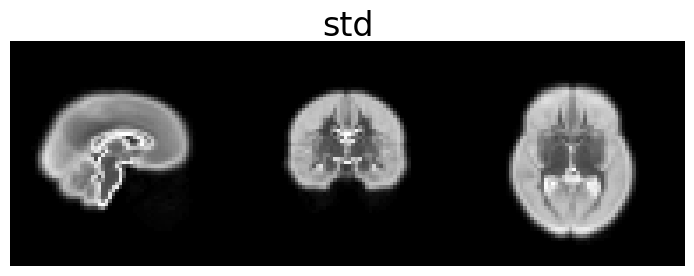

In [15]:
sdarr = arr.std(axis=0)
im.new_image_like(sdarr).plot_ortho(flat=True,xyz_lines=False,orient_labels=False,title='std')

In [16]:
corr2mean = np.array([np.corrcoef(marr.flatten(),arr[i,:,:,:].flatten())[0,1] for i in tqdm(range(arr.shape[0]))])

100%|██████████████████████████████████████████████████████████████████████████████| 4833/4833 [00:15<00:00, 302.50it/s]


Text(0.5, 1.0, 'M=0.912,SD=0.016. Range=0.792-0.943')

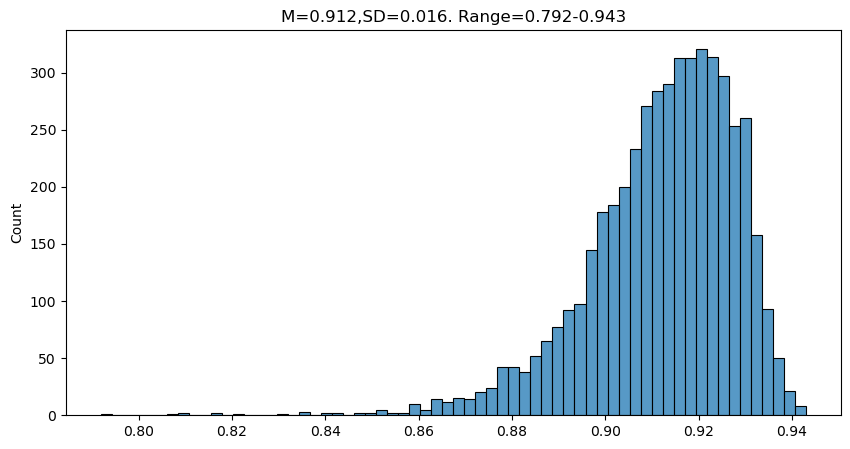

In [17]:
plt.figure(figsize=(10,5))
sns.histplot(corr2mean)
plt.title(f'M={corr2mean.mean():.3f},SD={corr2mean.std():.3f}. Range={corr2mean.min():.3f}-{corr2mean.max():.3f}')

In [18]:
good_subs = np.array(good_subs)
good_subs[0:5]

array(['sub-NDARINV5MJHVEB8', 'sub-NDARINV36E4JVZ2',
       'sub-NDARINVCR43W7MR', 'sub-NDARINVGK2BKPLT',
       'sub-NDARINVNGJJTJJD'], dtype='<U19')

In [19]:
subnames_adhd = [f'sub-{val}'.replace('_','') for val in subs_adhd['subjectkey'].values]
subnames_td = [f'sub-{val}'.replace('_','') for val in subs_td['subjectkey'].values]

subnames_adhd = np.array(subnames_adhd)
subnames_td = np.array(subnames_td)

In [20]:
idxs_adhd = np.array([good_sub in subnames_adhd for good_sub in good_subs])
idxs_td = np.array([good_sub in subnames_td for good_sub in good_subs])

print(idxs_adhd.sum())
print(idxs_td.sum())

959
3874


In [21]:
ofn_adhd = f'./Data/brain_arr_64_ADHD_{idxs_adhd.sum()}.npz'
# np.savez_compressed(ofn_adhd,arr=arr[idxs_adhd,:,:,:],subs=good_subs[idxs_adhd])

In [22]:
ofn_td = f'./Data/brain_arr_64_TD_{idxs_td.sum()}.npz'
# np.savez_compressed(ofn_td,arr=arr[idxs_td,:,:,:],subs=good_subs[idxs_td])

In [23]:
## Check
# print(np.load(ofn_adhd)['arr'].shape)
# print(np.load(ofn_adhd)['subs'].shape)

# print(np.load(ofn_td)['arr'].shape)
# print(np.load(ofn_td)['subs'].shape)